In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.special import comb

import seaborn as sns

from matplotlib import pyplot as plt

C:\Users\Stepan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def q1(x):
    return x.quantile(0.1)

def q3(x):
    return x.quantile(0.9)

def intraclust_dist_mean(df):
    sum_dists = 0
    sum_pairs = 0
    for cluster in df['Кластер'].unique():
        sum_dists += euclidean_distances(df[df['Кластер']==cluster].drop(columns=['Кластер'])).sum()/2
        sum_pairs += comb(df[df['Кластер']==cluster].shape[0], 2)
    return sum_dists / sum_pairs

<font size="6">Предобработка и отбор ППС</font>

In [3]:
data = pd.read_excel('output.xlsx', sheet_name='Sheet1')
data['ФИО'] = data['ФИО'].str.title()
data = data.groupby(['ФИО']).sum().reset_index()
PPS = pd.read_excel('общий массив данных ППС 14.01.20.xlsx', sheet_name='Sheet1')
PPS['ФИО'] = PPS['ФИО'].str.title()
data = data[data['ФИО'].isin(PPS['ФИО'])].reset_index(drop=True)
data = data.drop(columns=['Бухгалтерская', 'Отработано дней'])
data = data.set_index('ФИО')
summary_true = data.drop(columns=['Отработано часов']).sum(axis=1)

<font size="6">Оплата за год / масштабированные данные</font>

In [4]:
data = data.drop(columns=['Зависимые выплаты', 'Базовые выплаты', 'Отработано часов'])
print('Признаки')
print(list(data.columns))

Признаки
['Административная', 'Больничные', 'ДПО', 'Командировочные', 'Научная', 'Социальная', 'Стимулирование науки', 'Учебная']


In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

<font size="6">Иерархическая и К-средних кластеризация</font>

In [6]:
Z = linkage(data, method='ward')
mean_dists = []
for num_clusters in range(30, 1, -1):
    hierarchical_clusters = fcluster(Z, num_clusters, criterion='maxclust')
    data['Кластер'] = pd.Series(hierarchical_clusters, index=data.index)
    centers = data.groupby(['Кластер']).mean()
    data = data.drop(columns=['Кластер'])
    Kmean_clust = KMeans(n_clusters=num_clusters, init=centers, n_init=1).fit(data)
    Kmeans_clusters = Kmean_clust.labels_ + 1
    data['Кластер'] = pd.Series(Kmeans_clusters, index=data.index)
    dist = intraclust_dist_mean(data)
    mean_dists.append(dist)
    data = data.drop(columns=['Кластер'])
    print('кол-кластеров', str(num_clusters), '\t|', 'ср. внутрикласт. расст.', str(dist))

кол-кластеров 30 	| ср. внутрикласт. расст. 0.05976864068666588
кол-кластеров 29 	| ср. внутрикласт. расст. 0.06408183681586102
кол-кластеров 28 	| ср. внутрикласт. расст. 0.0652909582590132
кол-кластеров 27 	| ср. внутрикласт. расст. 0.06565901570498896
кол-кластеров 26 	| ср. внутрикласт. расст. 0.06587557783691655
кол-кластеров 25 	| ср. внутрикласт. расст. 0.06662910743337147
кол-кластеров 24 	| ср. внутрикласт. расст. 0.06719134636981411
кол-кластеров 23 	| ср. внутрикласт. расст. 0.06890285132695641
кол-кластеров 22 	| ср. внутрикласт. расст. 0.0705283940598819
кол-кластеров 21 	| ср. внутрикласт. расст. 0.07064039910923797
кол-кластеров 20 	| ср. внутрикласт. расст. 0.07219135561757807
кол-кластеров 19 	| ср. внутрикласт. расст. 0.07425859811312006
кол-кластеров 18 	| ср. внутрикласт. расст. 0.0825239931500972
кол-кластеров 17 	| ср. внутрикласт. расст. 0.08916636585510729
кол-кластеров 16 	| ср. внутрикласт. расст. 0.08956348336462368
кол-кластеров 15 	| ср. внутрикласт. расст.

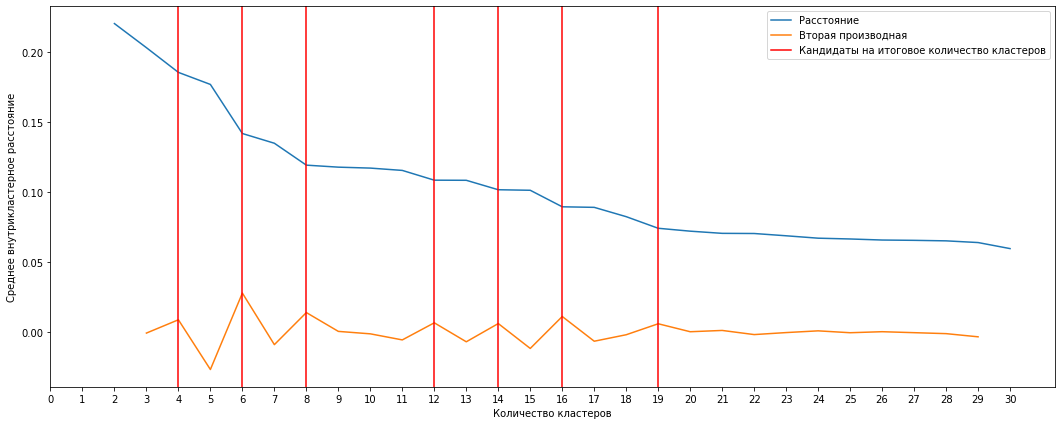

In [7]:
plt.figure(figsize=(18, 7))
idxs = np.arange(2, len(mean_dists) + 2)
plt.plot(idxs, mean_dists[::-1])

acceleration = np.diff(mean_dists[::-1], 2)  # 2nd derivative of the distances
plt.plot(idxs[:-2] + 1, acceleration)

for num_clust in (acceleration.argsort()[-7:][::-1] + 3).tolist():
    plt.axvline(num_clust, color='r')

plt.xlabel('Количество кластеров')
plt.ylabel('Среднее внутрикластерное расстояние')
plt.legend(("Расстояние", "Вторая производная", 'Кандидаты на итоговое количество кластеров'))
plt.xticks(np.arange(0,31,1))

plt.show()

In [8]:
num_hierarchical_clusters = 19
hierarchical_clusters = fcluster(Z, num_hierarchical_clusters, criterion='maxclust')

data['Кластер'] = pd.Series(hierarchical_clusters, index=data.index)
centers = data.groupby(['Кластер']).mean()
data = data.drop(columns=['Кластер'])
Kmean_clust = KMeans(n_clusters=num_hierarchical_clusters, init=centers, n_init=1).fit(data)
Kmeans_clusters = Kmean_clust.labels_ + 1
a = Kmeans_clusters - hierarchical_clusters
unique, counts = np.unique(a, return_counts=True)
trans_obj = data.shape[0] - dict(zip(unique, counts))[0]
print(trans_obj, 'объекта перешли в другой кластер после К-средних')
print('это', round(trans_obj*100 / data.shape[0], 2), '%')

64 объекта перешли в другой кластер после К-средних
это 14.25 %


In [9]:
data['Кластер'] = pd.Series(Kmeans_clusters, index=data.index)

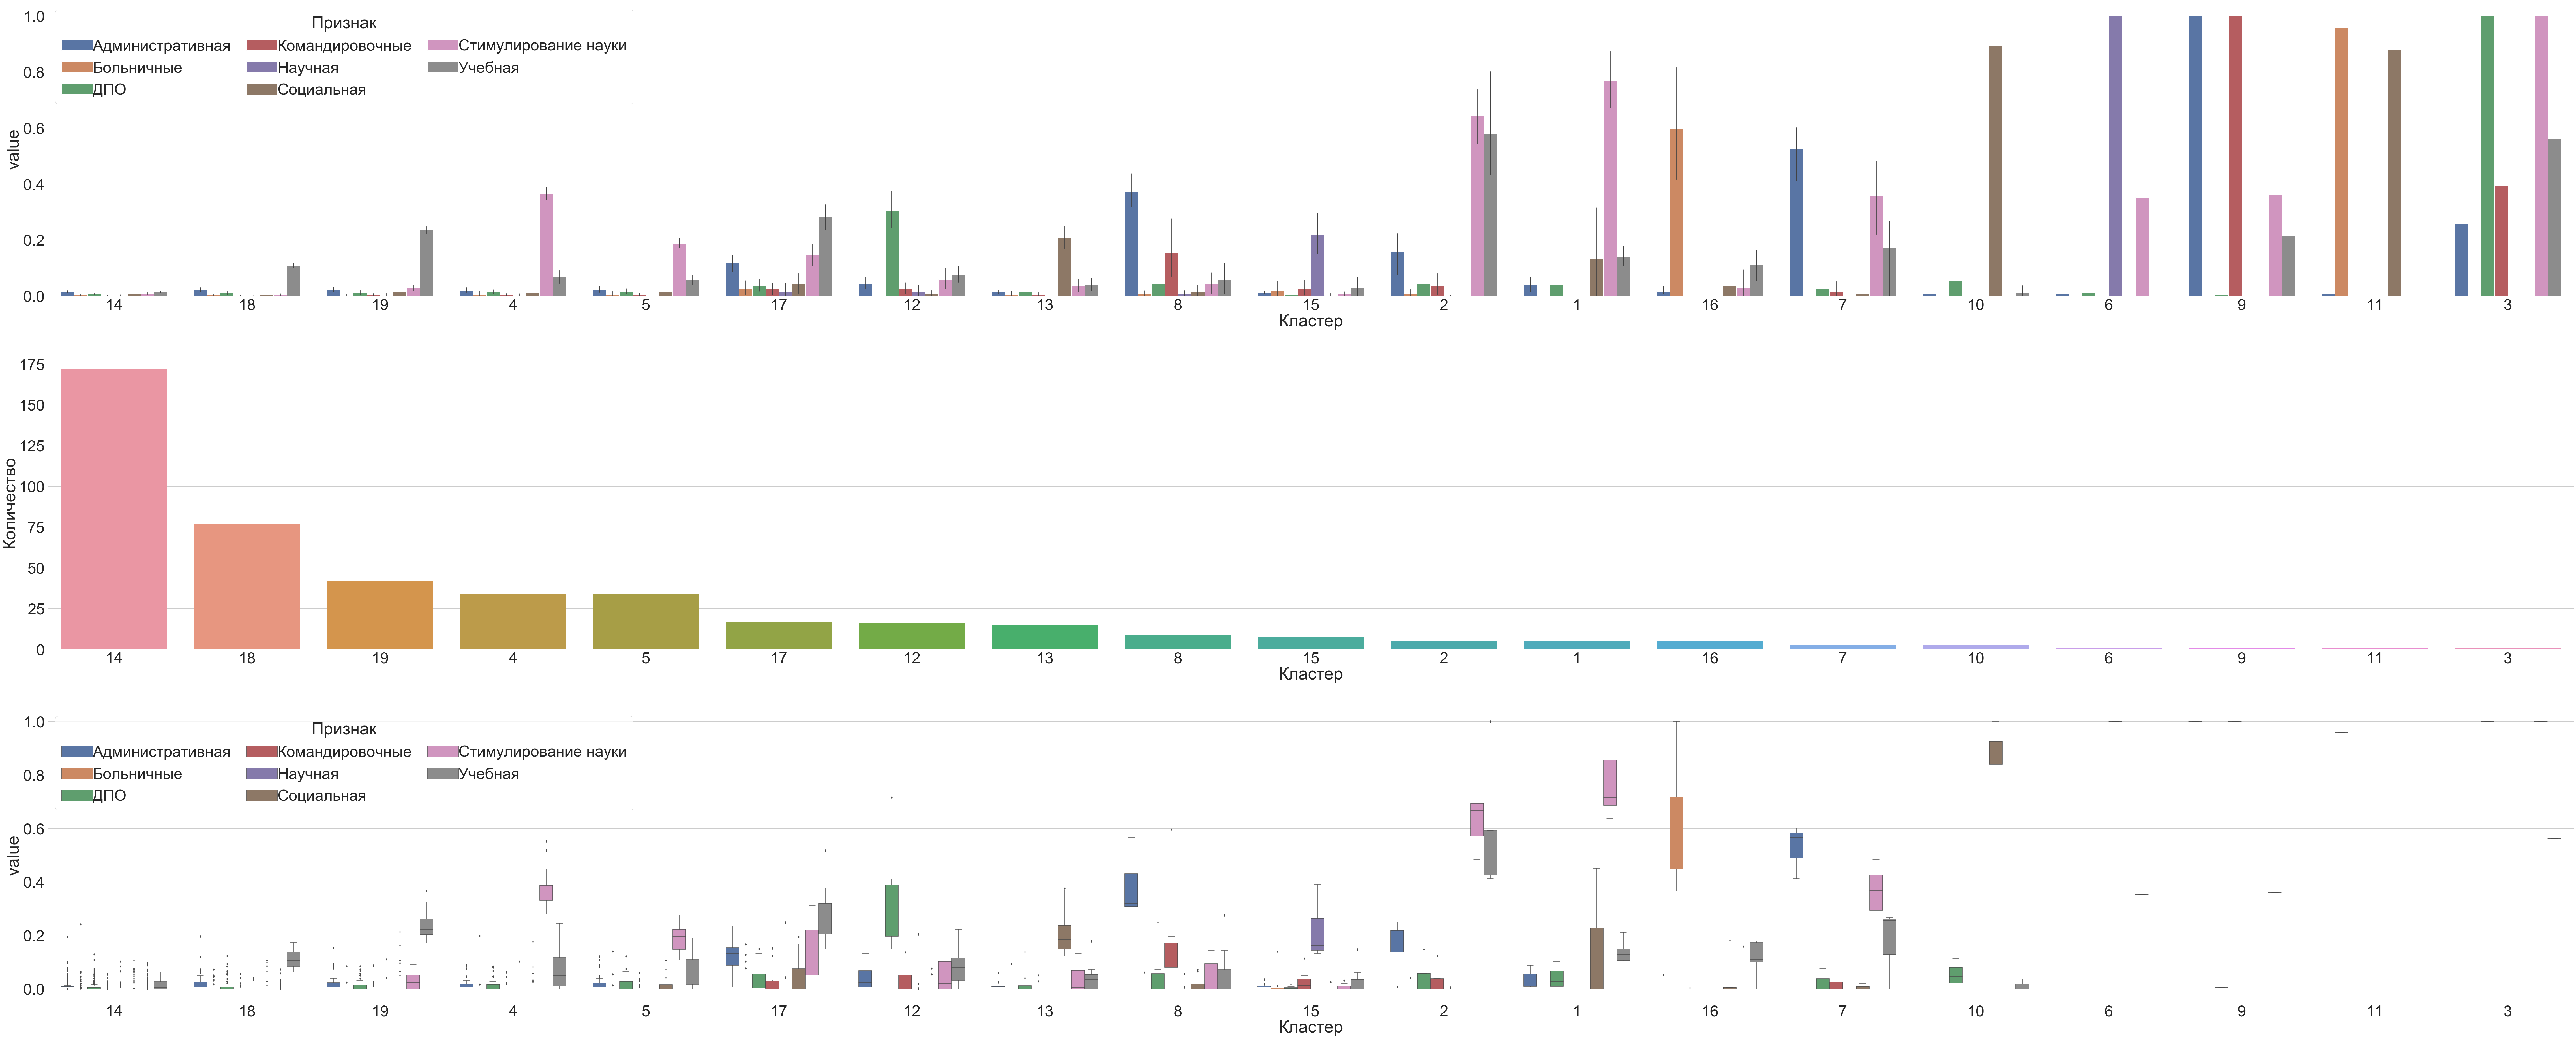

In [10]:
sns.set(style="whitegrid", font_scale=5)

# "Melt" the dataset to "long-form" or "tidy" representation
data_for_visual = pd.melt(data, "Кластер").sort_values(by=['Кластер']).reset_index(drop=True)#pd.melt(data_scaled, "Кластер")

# Initialize the figure
f, ax = plt.subplots(figsize=(160,65), nrows=3)
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
#sns.stripplot(x="value", y="variable", hue="Кластер", data=data_for_visual, dodge=True, jitter=True, alpha=0.4, zorder=1)

features = data.columns[:-1].to_list()
colors = sns.color_palette("Blues", 6).as_hex() + sns.color_palette("Greens", 6).as_hex() + sns.color_palette("Reds", 10).as_hex()
dict_featue_color = dict(zip(features, colors))
sns.countplot(Kmeans_clusters, ax=ax[1], order=pd.Series(Kmeans_clusters).value_counts().index)
ax[1].set_xlabel('Кластер')
ax[1].set_ylabel('Количество')
sns.boxplot(x="Кластер", y="value", hue='variable', data=data_for_visual, hue_order=features, ax=ax[2], order=pd.Series(Kmeans_clusters).value_counts().index)#, palette=dict_featue_color)
sns.barplot(x="Кластер", y="value", hue='variable', data=data_for_visual, ci=95, hue_order=features, ax=ax[0], order=pd.Series(Kmeans_clusters).value_counts().index)#, palette=dict_featue_color)

# Show the conditional means
#sns.pointplot(x="value", y="variable", hue="Кластер", data=data_for_visual, dodge=.71, join=False, palette=None, markers="d", ci=None)

# Improve the legend 
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:], labels[:], title="Признак",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[:], labels[:], title="Признак",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)

f.savefig('Визуализация кластеров', bbox_inches='tight')
sns.set(style="ticks", font_scale=1)

In [54]:
data['Сумма'] = summary_true
data = data[['Сумма', 'Кластер']]

In [56]:
cluster_stats = data.groupby(['Кластер'], as_index=True).agg({'Сумма':['mean','median',q1,q3,'min','max','count']})
cluster_stats.columns = cluster_stats.columns.droplevel()
cluster_stats = cluster_stats.reset_index().set_index('Кластер')

In [11]:
tsne_representation = TSNE(random_state=1, perplexity=20).fit_transform(data.drop(columns=['Кластер']))

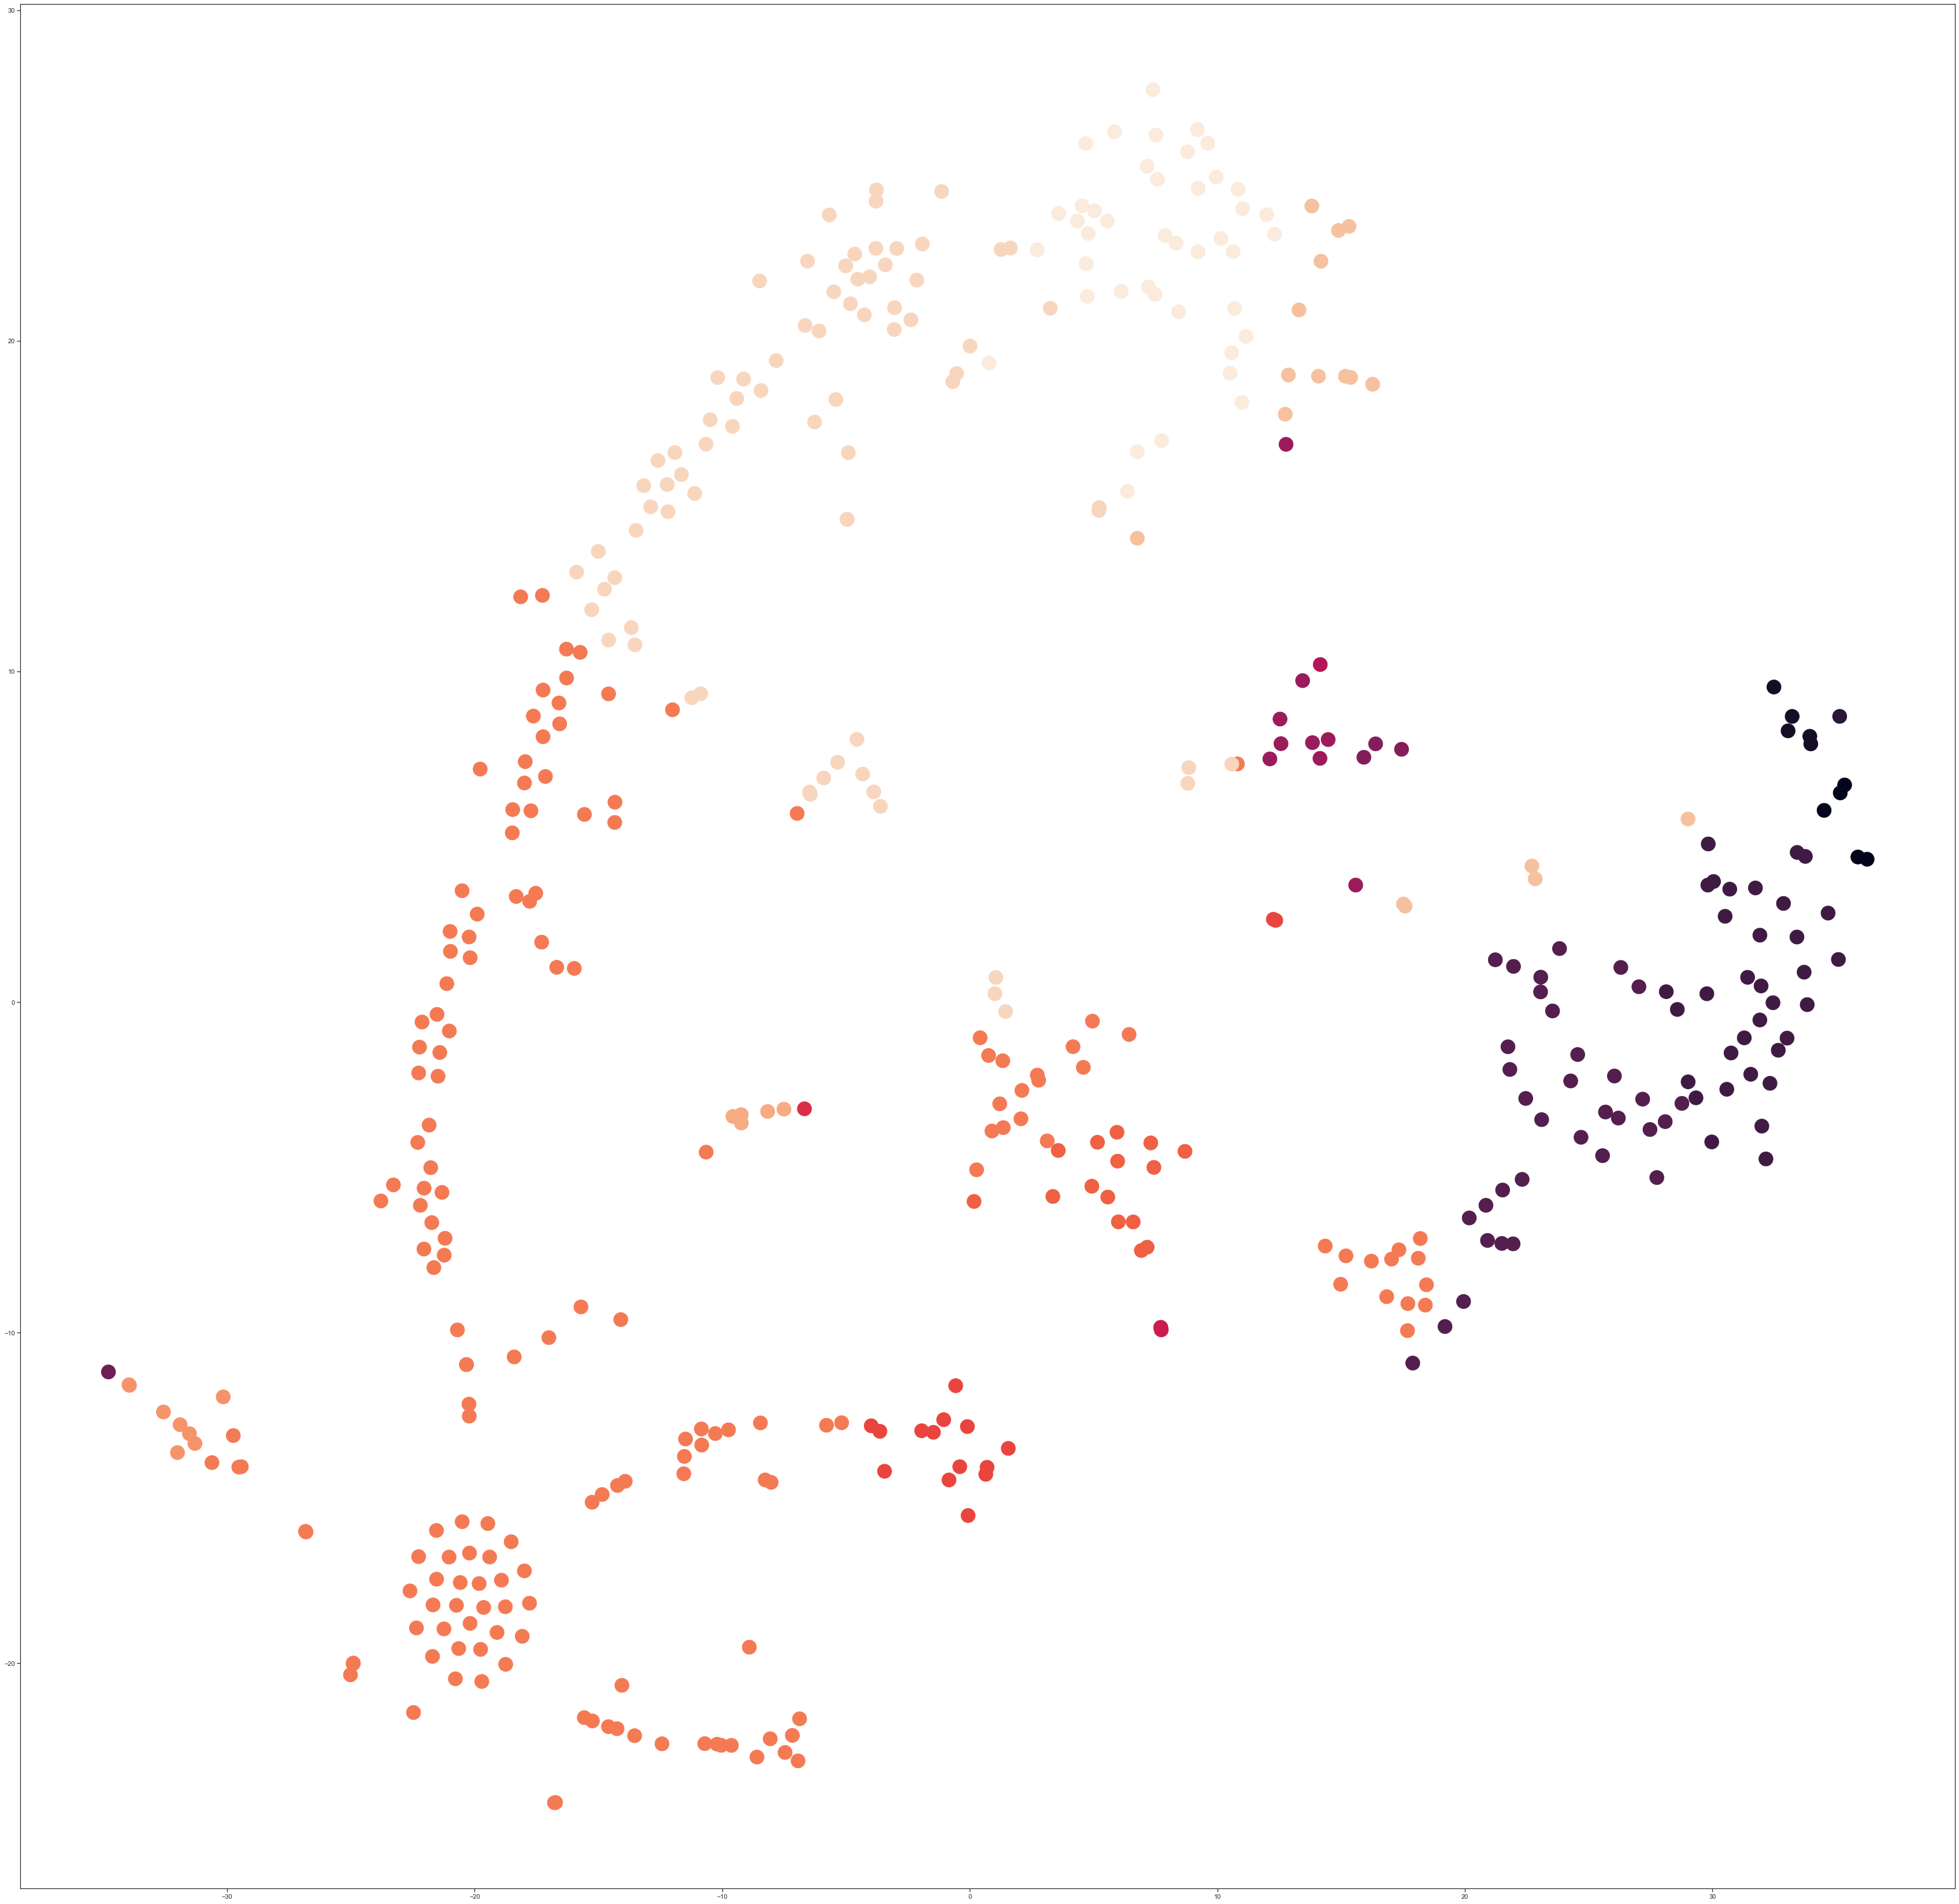

In [12]:
fig, ax = plt.subplots(figsize=(60,60))
ax.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=data['Кластер'], s=600)

#for i, txt in enumerate(data.index):
#    ax.annotate(txt, (tsne_representation[:, 0][i], tsne_representation[:, 1][i]))

#fig.savefig('temp', bbox_inches='tight')
plt.show()